In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import re
from collections import Counter

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.head()

,artist,title,lyrics,character_count,word_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...",2371,447
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,2689,551
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...",1576,304
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...",2203,446
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...",1570,318


In [4]:
df.reset_index(drop=True,inplace=True)

In [5]:
df = df.drop(['character_count', 'word_count'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252 entries, 0 to 6251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  6252 non-null   object
 1   title   6252 non-null   object
 2   lyrics  6252 non-null   object
dtypes: object(3)
memory usage: 146.7+ KB


In [7]:
df.head()

,artist,title,lyrics
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-..."


In [8]:
df.tail()

,artist,title,lyrics
6247,Lost Boyz,Lifestyles Of The Rich And Shameless,>Freaky Tahverses Mr. CheeksIntro:[Freaky Tah]...
6248,DJ Quik,Safe + Sound,"~Static~ ""Quik you're not a gangster we're not..."
6249,Ty Herndon,What Mattered Most,I thought I knew the girl so well If she was ...
6250,Madonna,Bedtime Story,Today Is the last day That I'm using words ...
6251,Livin' Joy,Dreamer,"Love, life and laughter Is all I beleive. My..."


In [9]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()


def remove_bracketed(song):
    text = re.sub("\[.*?\]", '', song)
    text = re.sub("\(.*?\)", '', text)
    text = re.sub("\{.*?\}", '', text)
    
    return text


def spacy_tokenizer(text, use_stopwords=True, custom_stopwords=set()):
    text = remove_bracketed(text)
    mytokens = parser(text)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else "-PRON-" for word in mytokens ]
#     mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    if use_stopwords:
        mytokens = [word for word in mytokens if word not in (stop_words | custom_stopwords) and word not in punctuations ]
    else:
        mytokens = [word for word in mytokens if word not in punctuations ]

    return mytokens


def tokenize_column(dataframe, column_name, use_stopwords=True, custom_stopwords=set()):
    df_ = dataframe.reset_index(drop=True)
    token_list = []
    for song in df_[column_name]:
        token_list.append(spacy_tokenizer(song, use_stopwords, custom_stopwords))
    
    return token_list



In [10]:
lyric_stopwords = set(['hey', 'baby', 'babe', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah', 'yeah'])
df['lyrics_tokens'] = tokenize_column(df, 'lyrics', use_stopwords=True, custom_stopwords=lyric_stopwords)

In [11]:
df.head(10)

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."
5,Justin Bieber Featuring Quavo,Intentions,"Picture perfect, you don't need no filter Gor...","[picture, perfect, need, filter, gorgeous, -PR..."
6,DaBaby Featuring Roddy Ricch,ROCKSTAR,"Woo, woo I pull up like How you pull up, Bab...","[pull, pull, pull, pull, pull, let, -PRON-, br..."
7,Future Featuring Drake,Life Is Good,Workin' on the weekend like usual Way off in ...,"[workin, weekend, usual, way, deep, end, usual..."
8,Billie Eilish,everything i wanted,I had a dream I got everything I wanted Not ...,"[dream, want, -PRON-, think, -PRON-, bein, hon..."
9,Camila Cabello Featuring DaBaby,My Oh My,"Ha, ha, ha, ha They say he likes a good time ...","[good, time, come, alive, midnight, mama, trus..."


In [12]:
idx = np.random.randint(0, 6252)

In [13]:
print(df.iloc[idx, 0], ' - ', df.iloc[idx, 1],'\n\n-----\n\n', df.iloc[idx, 2], '\n\n-----\n\n', df.iloc[idx, 3])

Dixie Chicks  -  Travelin' Soldier 

-----

 Two days past eighteen  He was waiting for the bus in his army greens  Sat down in a booth in a cafe there   Gave his order to a girl with a bow in her hair  He's a little shy so she give him a smile  So he said would you mind sittin' down for a while   And talking to me, I'm feeling a little low   She said I'm off in an hour and I know where we can go   So they went down and they sat on the pier   He said I bet you got a boyfriend but I don't care   I got no one to send a letter to   Would you mind if I sent one back here to you   I cried   Never gonna hold the hand of another guy   Too young for him they told her   Waitin' for the love of a travelin' soldier   Our love will never end   Waitin' for the soldier to come back again   Never more to be alone when the letter says   A soldier's coming home     So the letters came from an army camp   In California then Vietnam   And he told her of his heart   It might be love and all of the things 

In [14]:
barbra = df[df['artist'] == 'Duck Sauce']['lyrics'][2191]

In [15]:
barbra

'Barbra Streisand  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo   Owoowoowoowoowoo  Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoo  Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoo    Barbra Streisand    Woowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoow  Oowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowoowo  Owoowoowoowoowoo    Barbra Streisand    Wowowo wowowo wowowowoowoo  Woowoowoowoowoowoowoowoowoowoowoo wowowo wowowo 

In [16]:
set((re.sub("woo*", '', barbra.lower())).split())

{'(merci',
 'barbra',
 'cettes',
 'hugo',
 'o',
 'oo',
 'paroles)',
 'pour',
 'streisand',
 'w',
 'à'}

In [17]:
df.head()

,artist,title,lyrics,lyrics_tokens
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke..."
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f..."
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,..."
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let..."
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t..."


In [18]:
len(df.columns)

4

In [19]:
df['word_count'] = 0
df['unique_word_count'] = 0
for idx, row in enumerate(df['lyrics']):
    df.iloc[idx, len(df.columns)-2] = len(row.split())
    df.iloc[idx, len(df.columns)-1] = len(set(row.split()))

    
df['token_count'] = 0
df['unique_token_count'] = 0
for idx, row in enumerate(df['lyrics_tokens']):
    df.iloc[idx, len(df.columns)-2] = len(row)
    df.iloc[idx, len(df.columns)-1] = len(set(row))

In [20]:
df.head()

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
0,Drake,Toosie Slide,"Black leather gloves, no sequins (Yeah, yeah, ...","[black, leather, glove, sequin, buckles, jacke...",447,166,206,71
1,Roddy Ricch,The Box,Pullin' out the coupe at the lot Told 'em fuc...,"[pullin, coupe, lot, told, -PRON-, fuck, 12, f...",551,209,249,124
2,Dua Lipa,Don't Start Now,"If you don't wanna see me Did a full 180, cra...","[wanna, 180, crazy, thinking, way, heartbreak,...",304,100,87,31
3,Doja Cat,Say So,"Day and night til morning, keeping me in the m...","[day, night, til, morning, moment, -PRON-, let...",446,164,135,74
4,Post Malone,Circles,"Hey, hey, hey, hey Oh, oh, oh-oh Oh, oh, oh-...","[turn, til, upside, -PRON-, bad, guy, proud, t...",318,118,134,38


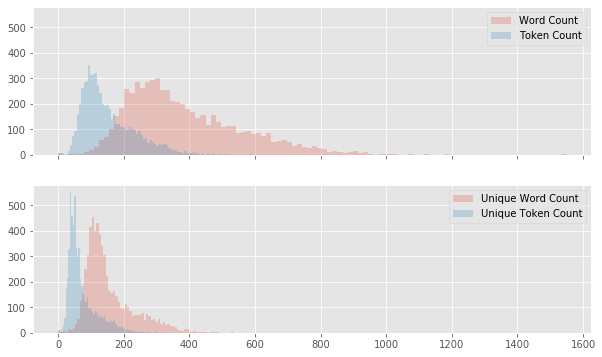

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
ax[0].hist(df['word_count'], bins=100, label='Word Count', alpha=.25)
ax[0].hist(df['token_count'], bins=100, label='Token Count', alpha=.25)
ax[1].hist(df['unique_word_count'], bins=100, label='Unique Word Count', alpha=.25)
ax[1].hist(df['unique_token_count'], bins=100, label='Unique Token Count', alpha=.25)
ax[0].legend(loc='best')
ax[1].legend(loc='best');

''

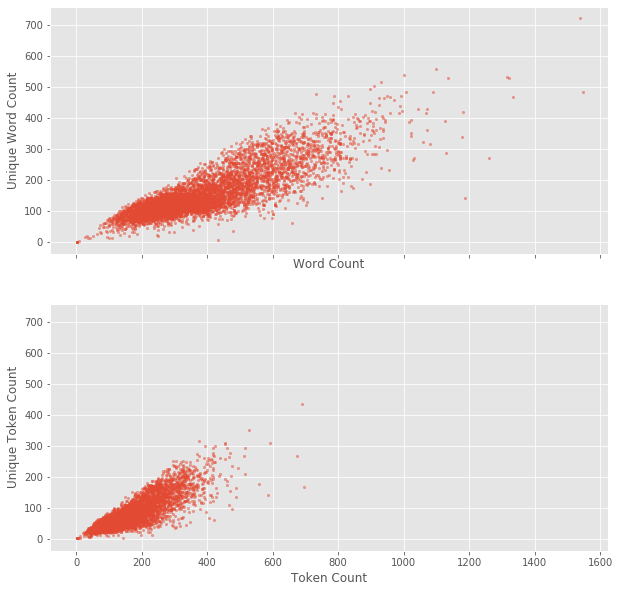

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
ax[0].scatter(df['word_count'], df['unique_word_count'], alpha=0.5, s=6)
ax[1].scatter(df['token_count'], df['unique_token_count'], alpha=0.5, s=6)
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Token Count')
ax[0].set_ylabel('Unique Word Count')
ax[1].set_ylabel('Unique Token Count')
;

In [23]:
df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6147,Nicki French,Total Eclipse Of The Heart,"Turnaround, Every now and then I get a little ...","[turnaround, little, bite, lonely, -PRON-, com...",1186,143,420,60


In [24]:
idx = df[(df['word_count'] > 1100) & (df['unique_word_count'] < 200)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.1205733558178752


In [25]:
df.iloc[idx,:]['lyrics']

"Turnaround, Every now and then I get a little bit lonely and you're never coming round  Turnaround, Every now and then I get a little bit tired of listening to the sound of my tears  Turnaround, Every now and then I get a little bit nervous that the best of all the years have gone by   Turnaround, Every now and then I get a little bit terrified and then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart    Turnaround, Every now and then I get a little bit restless and I dream of something wild  Turnaround, Every now and then I get a little bit helpless and I'm lying like a child in your arms  Turnaround, Every now and then I get a little bit angry and I know I've got to get out and cry  Turnaround, Every now and then I get a little bit terrified but then I see the look in your eyes  Turnaround bright eyes, Every now and then I fall apart  Turnaround bright eyes, Every now and then I fall apart  

In [26]:
df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
6127,Kool G Rap,Fast Life,"(feat. Nas) The time has come, we gotta expan...","[time, come, expand, operation, distribution, ...",732,477,376,316


In [27]:
idx = df[(df['word_count'] < 750) & (df['unique_word_count'] > 450)].index[0]
wc = df.iloc[idx,:]['word_count']
unique = df.iloc[idx,:]['unique_word_count']
print(unique / wc)

0.6516393442622951


In [28]:
df.iloc[idx,:]['lyrics']

'(feat. Nas)  The time has come, we gotta expand, the whole operation   Distribution, New York, to Chicago, L.A.  We gotta set our own market, and enforce it  [Verse One: Kool G Rap]    Champagne wishes of caviar dreams ?a penis didn\'t cream?  With sales of fish scales from triple beams I gleam  Livin the live of rowdy packin fifty cali\'s  Rockin lizard Bally\'s while we do our drug deal in a dark alley  Up in casinos just me and my dino primo  Pushin beam-o\'s then parlay in Reno with two fly latinos  Nas, he runs the whole staff, we count mad for seen bad  We\'ve seen a half a milli dashin out there on the Queens half  Three major players gettin papers by the layers  And those that portray us on the block get rocked like Domateus  Fakers get used to shootin targets, soon as the dark hits  Front on the drug market, bodies get rolled up in a carpet  Those that cheat us try to beat us we got hookers with heaters  that\'ll stray pop and put more shells in your top than Adidas  Da leade

In [29]:
df[df['title'] == 'Rap God']

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [30]:
wc = df[df['title'] == 'Rap God']['word_count'][1520]
unique = df[df['title'] == 'Rap God']['unique_word_count'][1520]
print(unique / wc)

0.4691358024691358


In [31]:
df[(df['token_count'] > 600) & (df['unique_token_count'] >400)]

,artist,title,lyrics,lyrics_tokens,word_count,unique_word_count,token_count,unique_token_count
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...","[look, easy, hurt, feeling, -PRON-, chance, wr...",1539,722,689,435


In [32]:
def tf(term, document_tokens):
    term_occ = document_tokens.count(term)
    total_tokens = len(document_tokens)
    return term_occ / total_tokens



def get_tf(document_tokens):
    term_freqs = {}
    for token in document_tokens:
        if token not in term_freqs:
            term_freqs[token] = tf(token, document_tokens)
    return term_freqs
    

def get_idf_dict(corpus):
    occ_dict = {}
    for doc in corpus:
        for token in doc:
            if token not in occ_dict:
                occ_dict[token] = 1
            else:
                occ_dict[token] += 1
    return occ_dict

def get_doc_freq_dict(corpus):
    doc_occs = Counter([word for row in corpus for word in set(row)])
    doc_freq = {k: (v / float(len(corpus))) for k, v in doc_occs.items()}
    return doc_freq


def vectorize_tokens(pandas_series):
    docs = pandas_series.to_numpy()
    doc_freq = get_doc_freq_dict(working_df['lyrics_tokens'])
    vocabulary = [k for k,v in doc_freq.items()]
    vectors = np.zeros((len(docs),len(vocabulary)))

    for i in range(len(docs)):
        for j in range(len(vocabulary)):
            term     = vocabulary[j]
            term_tf  = tf(term, docs[i])   # 0.0 if term not found in doc
            term_idf = np.log(1 + (1 / doc_freq[term])) # smooth formula
            vectors[i,j] = term_tf * term_idf
    return vectors, vocabulary



In [33]:
top_artist = df.groupby(by='artist').count().sort_values(by='title',ascending=False).loc[:,'title']
top_artist[:5]

artist
Taylor Swift     58
Kenny Chesney    42
Tim McGraw       39
Keith Urban      37
Drake            33
Name: title, dtype: int64

In [34]:
artist_list = list(top_artist[:5].index)
working_df = df[df['artist'].isin(artist_list)]

song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

In [35]:
song_is_artist.head()

,is_Drake,is_Keith Urban,is_Kenny Chesney,is_Taylor Swift,is_Tim McGraw
0,1,0,0,0,0
65,0,0,1,0,0
75,0,1,0,0,0
149,0,0,0,1,0
150,0,0,0,1,0


In [36]:
arr, vocab = vectorize_tokens(working_df['lyrics_tokens'])

model_df = pd.DataFrame(arr, columns=vocab)

In [37]:
def run_model(X, y, model_obj):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)
    model = model_obj
    
    model.fit(X_train, y_train)

    return model.score(X_test, y_test)


def get_all_scores(df, dummy_targets_df, model_obj):
    target_scores = {}
    X = df.to_numpy()
    vocab_to_remove = set()
    for idx, target in enumerate(dummy_targets_df.columns):
        y = dummy_targets_df.iloc[:,idx].to_numpy()
        score = run_model(X, y, model_obj)
        target_scores[target] = {'score': round(score, 3), 'imbalance': round((sum(y) / len(y)), 3)}
    
    return target_scores

In [38]:
def get_vocab_to_add(trained_model, col_names, add_perc=0.2):
    num_to_remove = int(len(col_names) * add_perc)
    feat_scores = pd.Series(rfc.feature_importances_,
                               index=col_names)
    top_feats = feat_scores.sort_values()[-num_to_remove:]
    return top_feats

In [198]:
# get_all_scores(model_df, song_is_artist, GaussianNB())

In [40]:
is_artist = 'is_Taylor Swift'

arr, vocab_cols = vectorize_tokens(working_df['lyrics_tokens'])
model_df = pd.DataFrame(arr, columns=vocab)

X = arr
y = song_is_artist.iloc[:,song_is_artist.columns.get_loc(is_artist)]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.20)

In [41]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_features='auto',
                             oob_score=True).fit(X_train, y_train)
rfc.score(X_test, y_test)

In [42]:
gbcl = GradientBoostingClassifier(learning_rate=.01, 
                                  n_estimators=100, 
                                  criterion='mae').fit(X_train, y_train)
gbcl.score(X_test, y_test)

In [43]:
gnb = GaussianNB().fit(X_train, y_train)
gnb.score(X_test, y_test)

0.7619047619047619

In [45]:
# model = GradientBoostingClassifier()
# learning_rate_param = [.01, .001]
# n_estimators_param = np.arange(100,3100,1000)
# parameters = {'n_estimators' : n_estimators_param,
#              'learning_rate' : learning_rate_param}
# clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# clf.fit(X_train,y_train)
# print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

In [46]:
# feat_scores = pd.Series(rfc.feature_importances_,
#                            index=vocab_cols)
# feat_scores = feat_scores.sort_values()[-50:]

# ax = feat_scores.plot(kind='barh', 
#                       figsize=(10,8),
#                       color='b')
# ax.set_title('Average Gini Importance')
# ax.set_xlabel('Average contribution to information gain');

# get_vocab_to_add(rfc, vocab_cols, add_perc=0.01)

In [325]:
artist_list = list(top_artist[:50].index)
working_df = df[df['artist'].isin(artist_list)]

song_is_artist = pd.get_dummies(working_df['artist'], prefix='is')

In [326]:
artist_list

['Taylor Swift',
 'Kenny Chesney',
 'Tim McGraw',
 'Keith Urban',
 'Drake',
 'Rascal Flatts',
 'Brad Paisley',
 'George Strait',
 'Toby Keith',
 'Jason Aldean',
 'Carrie Underwood',
 'Blake Shelton',
 'Eminem',
 'Rihanna',
 'Luke Bryan',
 'Kelly Clarkson',
 'P!nk',
 'Dierks Bentley',
 'Beyonce',
 'Britney Spears',
 'Alan Jackson',
 'Usher',
 'Madonna',
 'Maroon 5',
 'Chris Brown',
 'Brooks & Dunn',
 'R. Kelly',
 'Katy Perry',
 'J. Cole',
 'Nickelback',
 'Montgomery Gentry',
 'Eric Church',
 'Miranda Lambert',
 'Justin Timberlake',
 'Kendrick Lamar',
 'Billy Currington',
 'Dixie Chicks',
 'Lady Antebellum',
 'Jake Owen',
 'Backstreet Boys',
 'Lady Gaga',
 'Zac Brown Band',
 'Demi Lovato',
 'Mary J. Blige',
 'Christina Aguilera',
 'Lonestar',
 'Martina McBride',
 'The Black Eyed Peas',
 'Fall Out Boy',
 'Nicki Minaj']

In [315]:
lyric_stopwords = set(['hey', 'baby', 'babe', 'woo', 'ha', 'like', 'oh', 'ooh', 'woah', 'yeah'])
all_stop_words = lyric_stopwords.union(STOP_WORDS)

In [316]:
aggr_feat_imp_dict = {}

for artist in artist_list:
    is_artist = 'is_{}'.format(artist)
    y = song_is_artist.iloc[:,song_is_artist.columns.get_loc(is_artist)]

    X_train, X_test, y_train, y_test = train_test_split(working_df['lyrics'], 
                                                        y, 
                                                        test_size=.40)

    vectorizer = TfidfVectorizer(stop_words=all_stop_words, 
                                 ngram_range=(1,3),
    #                             , max_df=.8, 
    #                              min_df=.2, 
                                 max_features=10000
                                )
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    features = vectorizer.get_feature_names()

    imbrf = BalancedRandomForestClassifier(n_estimators=5000,
                                           max_features='auto', 
                                           sampling_strategy=0.5
                                          ).fit(X_train_vec, y_train)

    X_test_vec = vectorizer.transform(X_test)

    y_pred = imbrf.predict(X_test_vec)

    for score, term in zip(imbrf.feature_importances_, features):
        if term not in aggr_feat_imp_dict:
            aggr_feat_imp_dict[term] = score
        else:
            aggr_feat_imp_dict[term] += score

/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/sean/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tok

In [319]:
aggr_feat_imp_dict

{'10': 4.120148144778346e-05,
 '10 bands': 0.0,
 '10 bands 50': 0.0,
 '100': 0.0,
 '100 bands': 0.0,
 '100 bands fuck': 0.0,
 '15': 1.663511028122063e-05,
 '16': 0.0,
 '16 needed': 0.0,
 '16 needed john': 0.0,
 '17': 3.9428824121832696e-05,
 '20': 0.00013820636431686857,
 '22': 0.0,
 '22 22': 0.0,
 '22 22 feels': 0.0,
 '22 alright': 0.0,
 '22 alright don': 0.0,
 '22 feels': 0.0,
 '22 feels nights': 0.0,
 '24': 7.069653233224388e-06,
 '30': 7.358967596499903e-05,
 '40': 0.00029009898414390366,
 '45': 1.2925066328614182e-05,
 '50': 0.0,
 '50 bands': 0.0,
 '50 bands 100': 0.0,
 'abigail': 0.0,
 'act': 0.002051236092720829,
 'act little': 0.0,
 'act little little': 0.0,
 'action': 0.001263467464668884,
 'addiction': 1.815556436415537e-05,
 'addiction cause': 3.86883814826435e-05,
 'addiction cause fallin': 5.1747183796273825e-05,
 'afraid': 0.0010823553721714084,
 'afraid somebody': 0.0,
 'afraid somebody gonna': 0.0,
 'age': 0.0004258248369913336,
 'ago': 0.0001764354944565922,
 'ah': 0.0

In [320]:
max(aggr_feat_imp_dict.values())

0.05762413061412138

In [323]:
important_feats_dict = {}
not_important_feats_dict = {}
for k, v in aggr_feat_imp_dict.items():
    if v > 0.02:
        important_feats_dict[k] = v
    else:
        not_important_feats_dict[k] = v

In [324]:
important_feats_dict

{'ain': 0.020301098275396622,
 'cause': 0.03445780162602046,
 'come': 0.021972349569193056,
 'don': 0.04753508506897687,
 'don know': 0.028368492989710604,
 'em': 0.024482334310890346,
 'fuck': 0.02088830694174846,
 'girl': 0.027015754995470983,
 'gonna': 0.024847875727998132,
 'good': 0.02345623883372991,
 'got': 0.05762413061412138,
 'gotta': 0.023732824369390615,
 'knew': 0.02481143942197904,
 'know': 0.045617356755149406,
 'let': 0.03232951281644647,
 'life': 0.023727961217828396,
 'little': 0.03061550429994433,
 'live': 0.02054886457863471,
 'll': 0.04812858014623127,
 'long': 0.02591407894714338,
 'love': 0.036028734525343296,
 'man': 0.02841572987837018,
 'money': 0.02295284177708687,
 'need': 0.020311433356550727,
 'niggas': 0.03537694829175042,
 'night': 0.03188605648087442,
 'old': 0.02366019535885737,
 'right': 0.03392739721261795,
 'run': 0.02453076100819008,
 'said': 0.02732820557157433,
 'shit': 0.042066496598292986,
 'tell': 0.03673066903551937,
 'thing': 0.0258619792182

In [308]:
# feat_scores = pd.Series(imbrf.feature_importances_,
#                            index=features)
# feat_scores = feat_scores.sort_values()[:50]

# ax = feat_scores.plot(kind='barh', 
#                       figsize=(10,8),
#                       color='b')
# ax.set_title('Average Gini Importance')
# ax.set_xlabel('Average contribution to information gain');

In [290]:
print('Total songs: \t', len(working_df), 
      '\nTotal target: \t', sum(y), 
      '\nPercentage is target: \t', round((sum(y) / len(working_df)), 3), 
      '\nPercentage is not target: \t', round(((len(y) - sum(y)) / len(working_df)), 3))

Total songs: 	 706 
Total target: 	 19 
Percentage is target: 	 0.027 
Percentage is not target: 	 0.973


Precision: 0.333 
Recal: 0.25 
Accuracy: 0.982


Text(0.5, 1, 'is_Maroon 5')

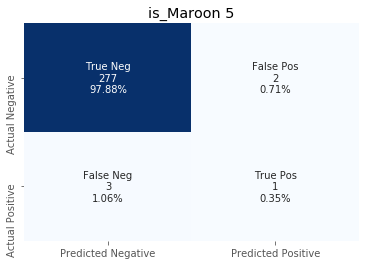

In [291]:
plot_conf_matrix(y_test, y_pred)
plt.title(is_artist)

In [270]:
imbrf.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [266]:
features

['000',
 '000 feet',
 '000 feet oklahoma',
 '000 plus',
 '000 plus young',
 '01',
 '01 walked',
 '01 walked saw',
 '02',
 '02 03',
 '02 03 dog',
 '02 burn',
 '02 burn ho',
 '03',
 '03 dog',
 '03 dog 40',
 '10',
 '10 bucks',
 '10 bucks right',
 '10 dollar',
 '10 dollar drinks',
 '10 dressing',
 '10 dressing pick',
 '10 feet',
 '10 feet air',
 '10 feet liftin',
 '10 year',
 '10 year old',
 '10 years',
 '10 years old',
 '10 years stopping',
 '101',
 '101 ventura',
 '101 ventura lost',
 '11',
 '11 look',
 '11 look record',
 '12',
 '12 cap',
 '12 cap tractor',
 '14',
 '14 wait',
 '14 wait someday',
 '14th',
 '14th avenue',
 '14th avenue lot',
 '15',
 '15 different',
 '15 different states',
 '15 fort',
 '15 fort york',
 '15 minutes',
 '15 minutes got',
 '16',
 '16 child',
 '16 child backseat',
 '16 drive',
 '16 drive boy',
 '16 john',
 '16 john cougar',
 '16 needed',
 '16 needed john',
 '16 needed right',
 '16 right',
 '16 spent',
 '16 spent lot',
 '17',
 '17 hard',
 '17 hard past',
 '17 pro

In [218]:
def plot_conf_matrix(actuals, predictions):
    cf_matrix = confusion_matrix(actuals, predictions)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, 
                annot=labels, 
                fmt='', 
                cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'], cbar=False)
    
    tn, fp, fn, tp = cf_matrix.flatten()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    print(f"Precision: {round(precision, 3)} \nRecal: {round(recall, 3)} \nAccuracy: {round(accuracy, 3)}")